# Trump Tweets
This project was inspired by listening to political podcasts during the COVID-19 pandemic while taking my first data science courses. I repeatedly heard pundits on these podcasts assert that the only thing Donald Trump cares about is the stock market. I heard the line repeated so frequently that I wondered if data science could be used to test the assertion. This project was born out of that question.

The basic concept was to perform sentiment analysis on all of Trump's tweets since assuming office and to compare the sentiment of his tweets to stock market performance. Because this was my first unguided data science project and because I'm interested in politics, there are also a number of exploratory diversions. I found the mildly interesting and hope that you will as well.

## Gathering the data.
After a full day of exploring (i.e. wrestling with) the Twitter API, I learned that Twitter only allows you to download the 3,200 most recent tweets on any given account. Unfortunately, Trump has tweeted far more than 3,200 time during his presidency. Fortunately, I was able to find an archive of his tweets at http://www.trumptwitterarchive.com/archive.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

tweets=pd.read_csv('tweets.csv')

At the time this code was run (the morning of May 20, 2020), Trump had tweeted 18,104 time during his presidency.

## Cleaning.
We begin with some basic cleaning, including removing links and mentions from the text of the tweets.

In [2]:
tweets['text'] = tweets['text'].str.replace('&amp;', '&')
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets['is_retweet']=tweets['is_retweet'].astype(bool)
tweets['hour'] = tweets['created_at'].dt.hour

In [3]:
tweets['clean_text'] = tweets['text'].str.replace(r'@([^\s]+)','')
tweets['clean_text'] = tweets['clean_text'].str.replace(r'(https?)://([^\s]+)','')

In [4]:
empty = tweets[tweets['clean_text']=='']
tweets = tweets[tweets['clean_text']!='']

## Sentiment analysis.

I used two forms of sentiment analysis, but decided to use the nltk analysis for the rest of the project because it appears to be a more sensitive metric and to account for more nuance, such as capitalization and punctuation.

In [5]:
from textblob import TextBlob

def get_pol_subj(row):
    #print(row['text'])
    text = TextBlob(row['clean_text'])
    row['polarity'] = text.sentiment[0]
    row['subjectivity'] = text.sentiment[1]
    
    return row
    
tweets = tweets.apply(get_pol_subj, axis=1)

In [6]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()

def vader(row):
    pol = sia.polarity_scores(row['clean_text'])
    #row['vader'] = pol
    row['vader_neg']= pol['neg']
    row['vader_neu']= pol['neu']
    row['vader_pos']= pol['pos']
    row['vader_compound'] = pol['compound']

    return row     

tweets = tweets.apply(vader, axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mattboutte/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The sentiment data is quite noisy, so rolling averages are computed based on various timelengths.

In [8]:
import numpy as np
import datetime

def rolling(row,days,cols):
    end_date = row['created_at']
    start_date = row['created_at']-datetime.timedelta(days=days)
    
    tweets_mask= (tweets['created_at']>=start_date) & (tweets['created_at']<=end_date)
    
    for col in cols:
        new_col_name = col+'_'+str(days)+'_days_rolling'
        row[new_col_name] =np.mean(tweets.loc[tweets_mask,col])
        
    return row

cols = ['polarity', 'vader_compound']
days = [0,7,15,30,45,60]
for day in days:    
    tweets = tweets.apply(rolling, axis=1,args=(day,cols))

## Market data.

The Dow Jones Industrial Average is used as a proxy for overal stockmarket performance. A separate dataframe with daily data is created and features are added calculating performance over various time intervals.

In [9]:
djia = pd.read_csv('djia.csv')

djia['Date'] = pd.to_datetime(djia['Date'])

djia['Week Change']=djia['Close'].pct_change(periods=5)
djia['Two Week Change']=djia['Close'].pct_change(periods=10)
djia['Three Week Change']=djia['Close'].pct_change(periods=15)
djia['One Month Change']=djia['Close'].pct_change(periods=20)
djia['Daily_Percent_Inc']=100*((djia['Close']/djia['Open'])-1)

def get_djia_info(row):
    date = row['created_at'].date()
    
    djia_date = djia['Date'].dt.date
    
    mask = (djia_date == date)
    
    while mask.sum() != 1:
        date = date - datetime.timedelta(days=1)
        mask = (djia_date == date)
        
    row['djia'] = djia[mask]['Close'].sum()
    row['djia_1_day'] = djia[mask]['Daily_Percent_Inc'].sum()
    row['djia_1_week'] = djia[mask]['Week Change'].sum()
    row['djia_2_week'] = djia[mask]['Two Week Change'].sum()
    row['djia_3_week'] = djia[mask]['Three Week Change'].sum()
    row['djia_4_week'] = djia[mask]['One Month Change'].sum()
    
    return row

tweets = tweets.apply(get_djia_info, axis=1)

## Other features.
Various other features are created.

In [10]:
def tweets_per_day(row):
    date = row['created_at'].date()
    
    mask = tweets['created_at'].dt.date == date
    
    row['daily_tweet_count']=mask.sum()
    return row

tweets = tweets.apply(tweets_per_day, axis=1)

In [11]:
tweets['date'] = tweets['created_at'].dt.date

In [13]:
tweets['impeachment'] = False

impeachment_start = datetime.datetime(2019,9,24)
impeachment_end = datetime.datetime(2020,1,6)

impeachment_mask= (tweets['created_at']>=impeachment_start) & (tweets['created_at']<=impeachment_end)

tweets.loc[impeachment_mask,'impeachment']=True

## The issue of retweets.
According to the data provided, Trump consistently retweeted, execpet during an approximately 11 month period, as seen in the plot. However, the tweets consistently contain 'RT' – even during this period. I'm not a heavy Twitter user, so I don't know exactly what this means.

I therefore created a boolean feature indicating whether the text of the tweets contains 'RT'.

In [15]:
tweets['contains_RT']=tweets['clean_text'].str.contains(r'\b(RT)\b')

retweets = tweets[tweets['is_retweet']]
originals = tweets[~tweets['is_retweet']]

<IPython.core.display.Javascript object>


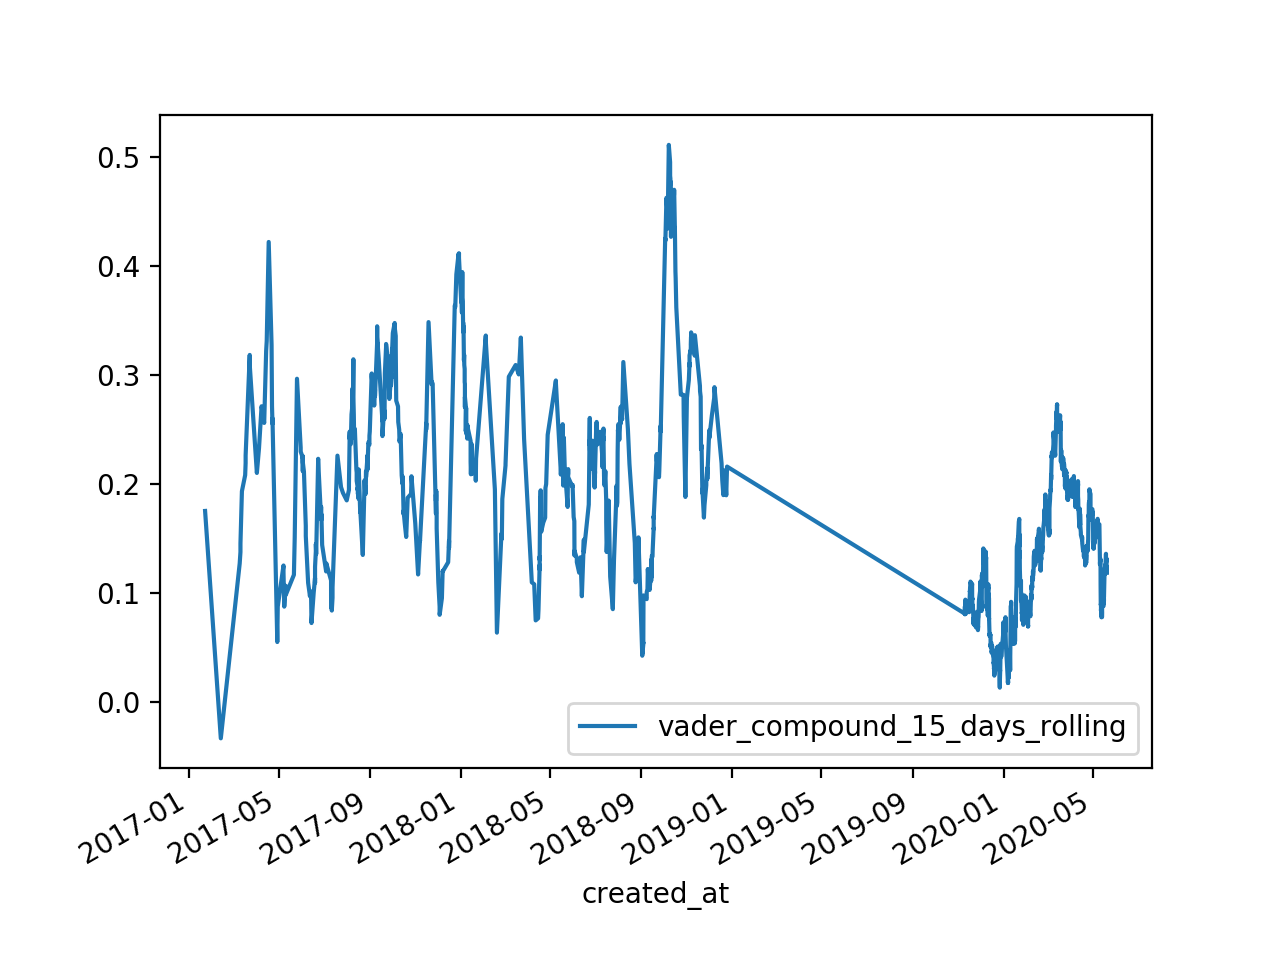

In [17]:
%matplotlib notebook

retweets.plot(x='created_at', y = 'vader_compound_15_days_rolling')

<IPython.core.display.Javascript object>


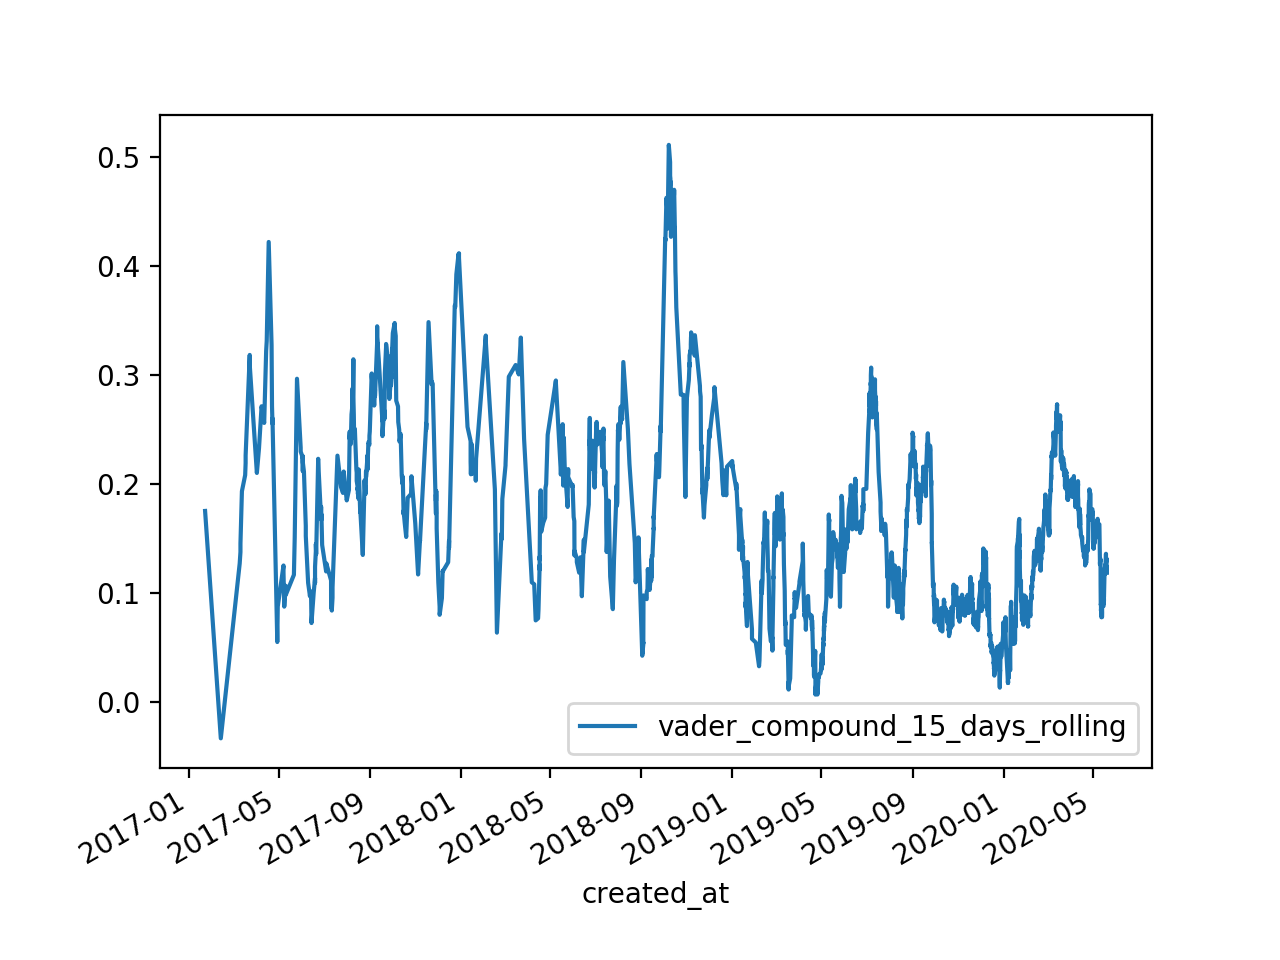

In [18]:
%matplotlib notebook

tweets[tweets['contains_RT']].plot(x='created_at', y = 'vader_compound_15_days_rolling')

## Visual analysis.

Various plots were created to start exploring the data.

<IPython.core.display.Javascript object>


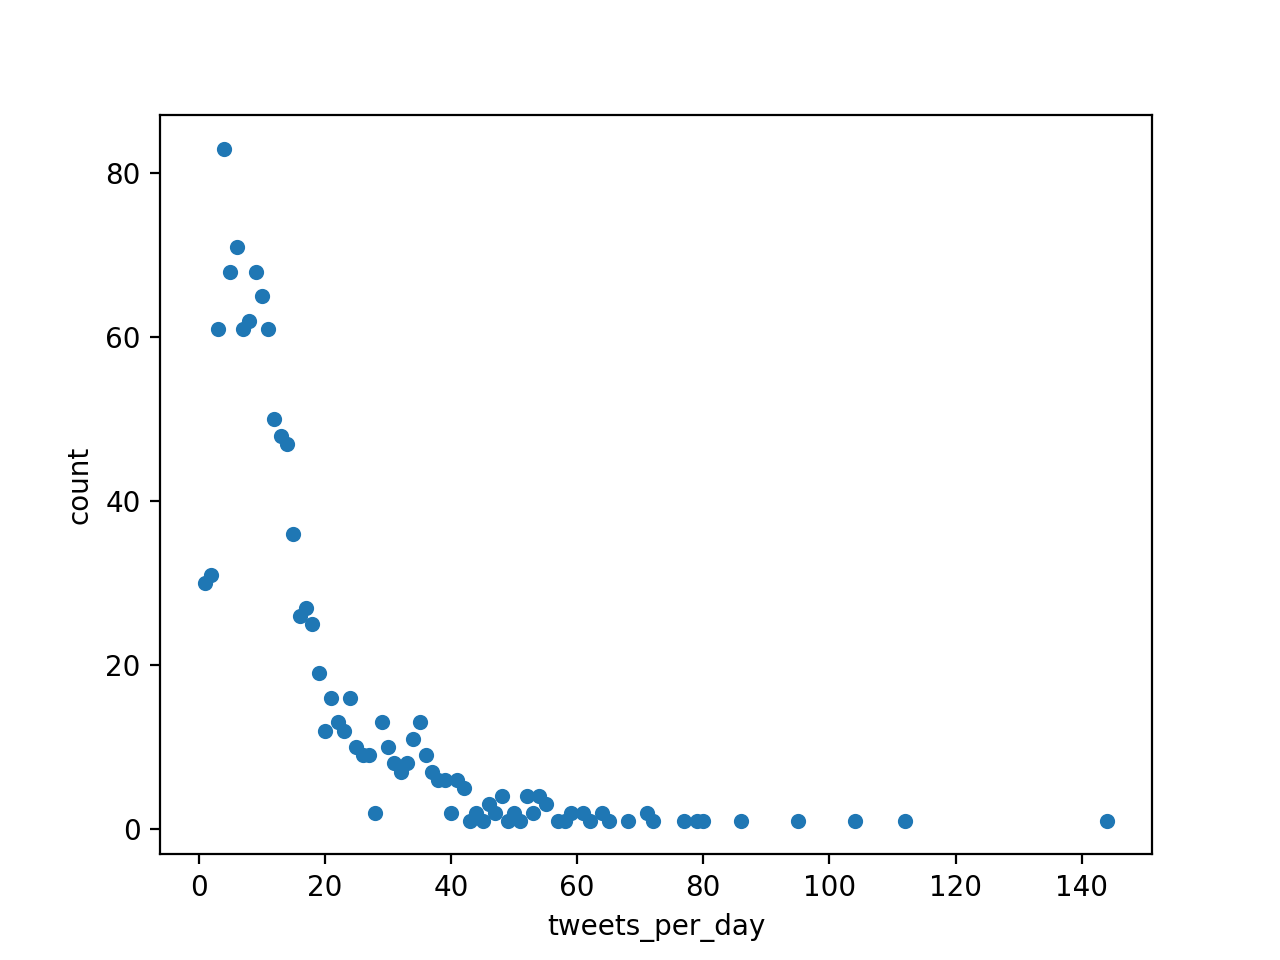

In [19]:
%matplotlib notebook

daily_count=tweets['date'].value_counts()
daily_count=daily_count.reset_index(drop=True)

df = pd.DataFrame(daily_count.value_counts())
df=df.reset_index()
df.columns=['tweets_per_day','count']

df.plot.scatter(x='tweets_per_day', y='count')

<IPython.core.display.Javascript object>


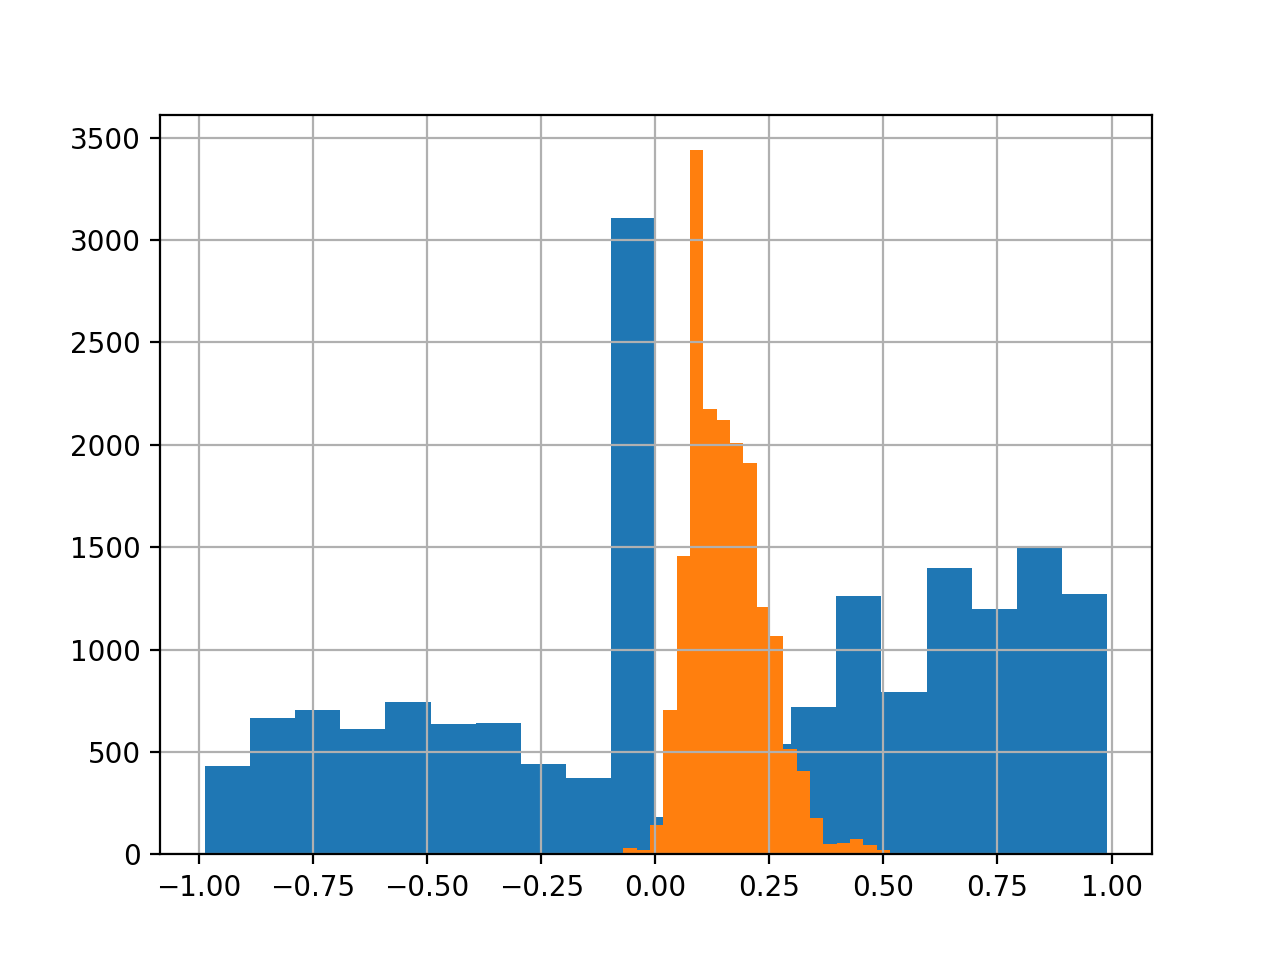

In [20]:
%matplotlib notebook

tweets['vader_compound'].hist(bins=20)
tweets['vader_compound_15_days_rolling'].hist(bins=20)

The sentiment was more positive on average than I was expecting.

<IPython.core.display.Javascript object>


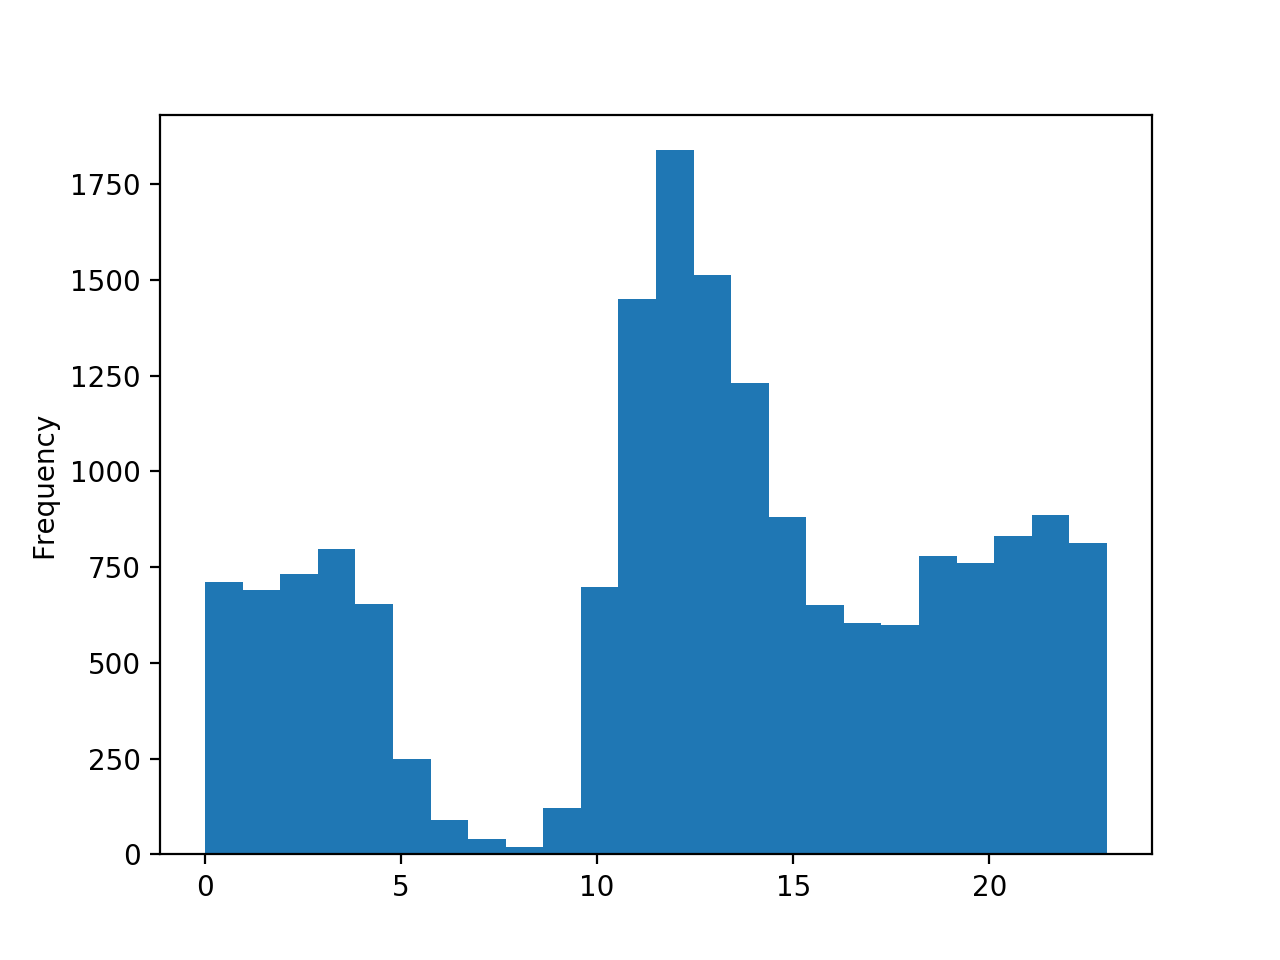

In [21]:
%matplotlib notebook

tweets['hour'].plot.hist(bins=24)

<IPython.core.display.Javascript object>


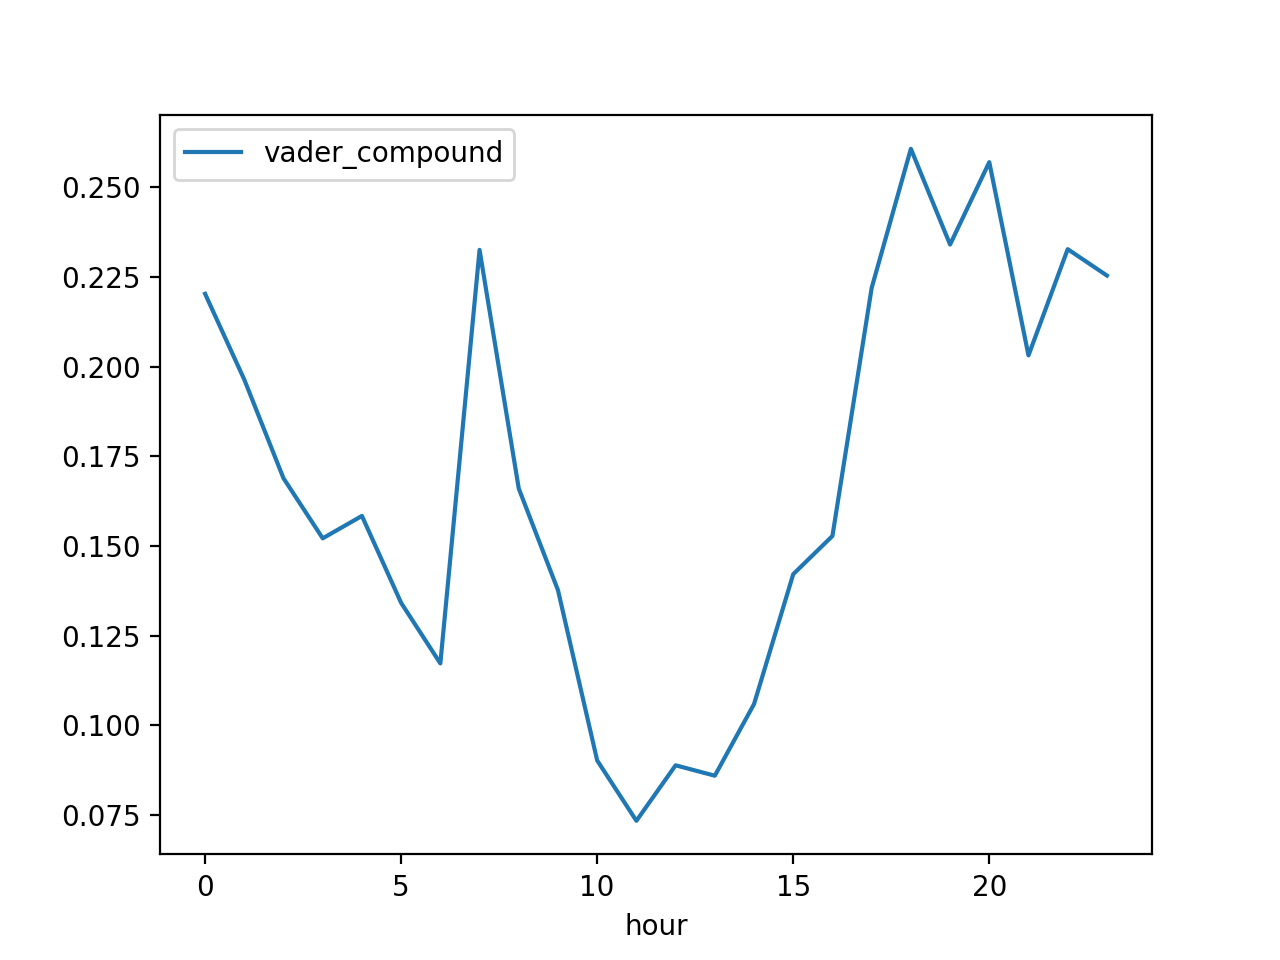

In [23]:
pivot= pd.pivot_table(tweets, values=['vader_compound'], index=['hour'])
pivot.reset_index(inplace=True)

%matplotlib notebook

pivot.plot.line(x='hour', y=['vader_compound'])

<IPython.core.display.Javascript object>


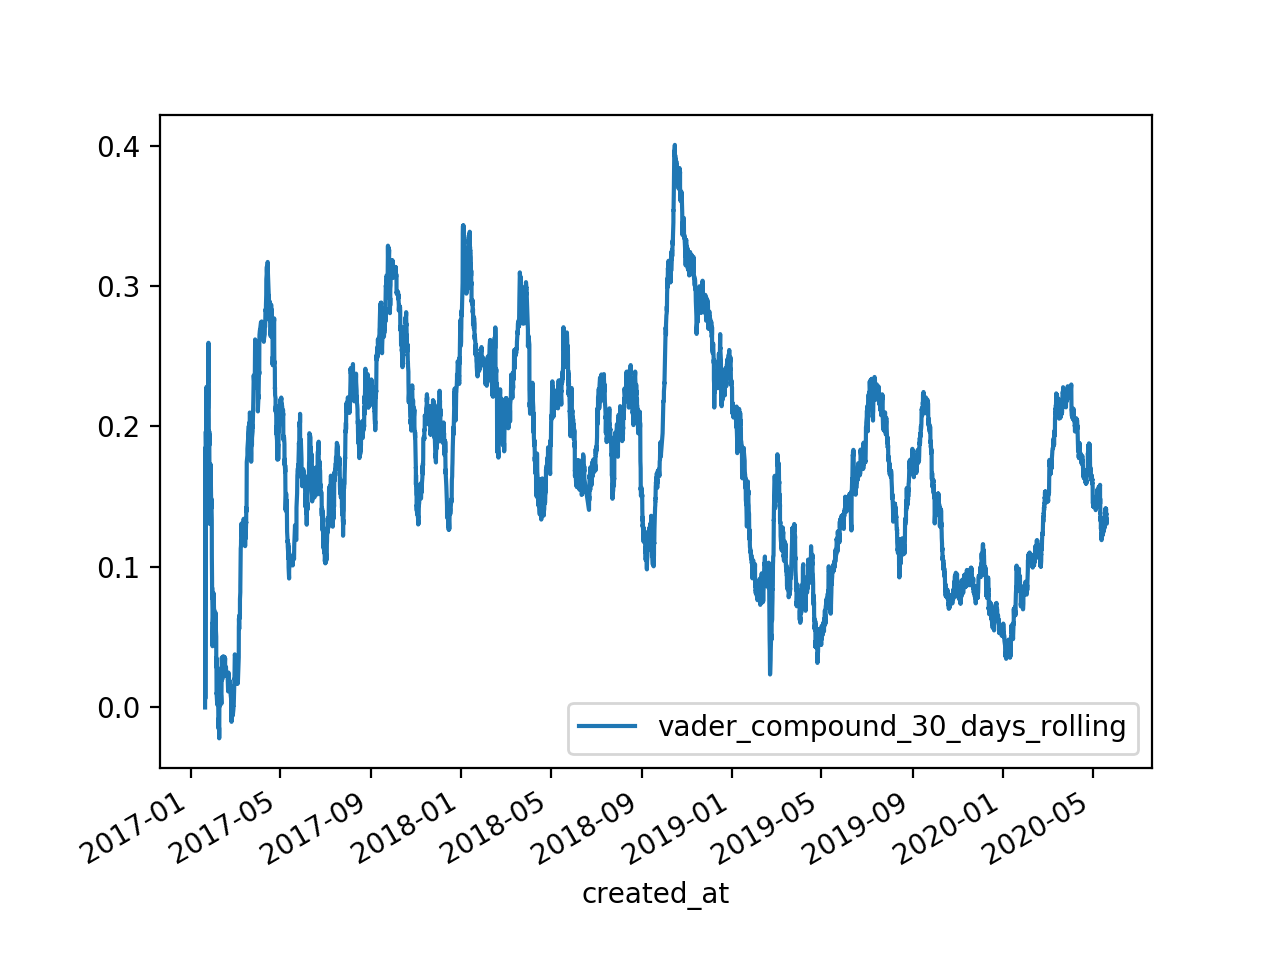

In [24]:
%matplotlib notebook
tweets.plot.line(x='created_at', y=['vader_compound_30_days_rolling'])

<IPython.core.display.Javascript object>


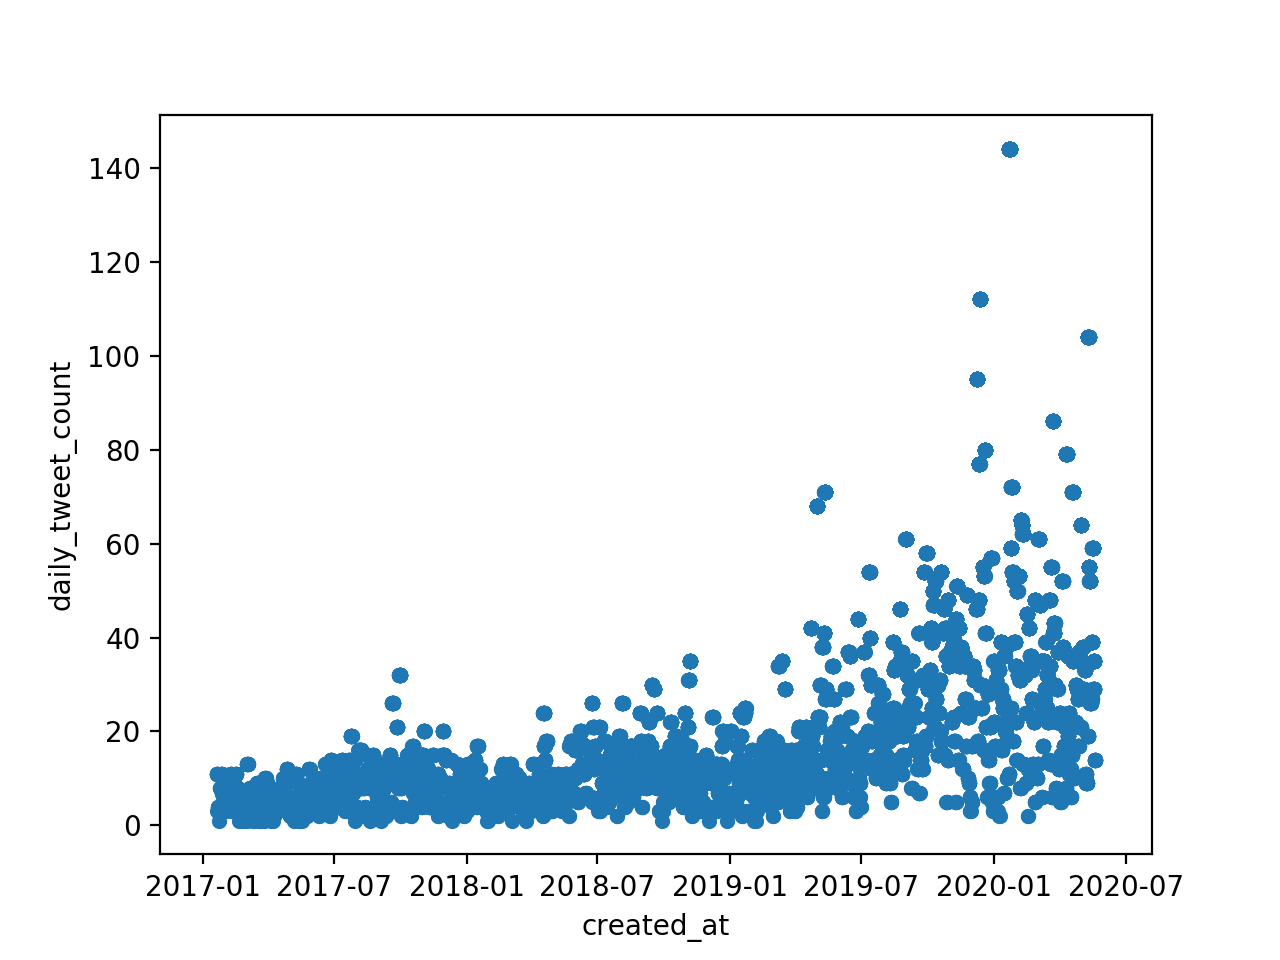

In [25]:
%matplotlib notebook

tweets.plot.scatter(x='created_at', y='daily_tweet_count')

<IPython.core.display.Javascript object>


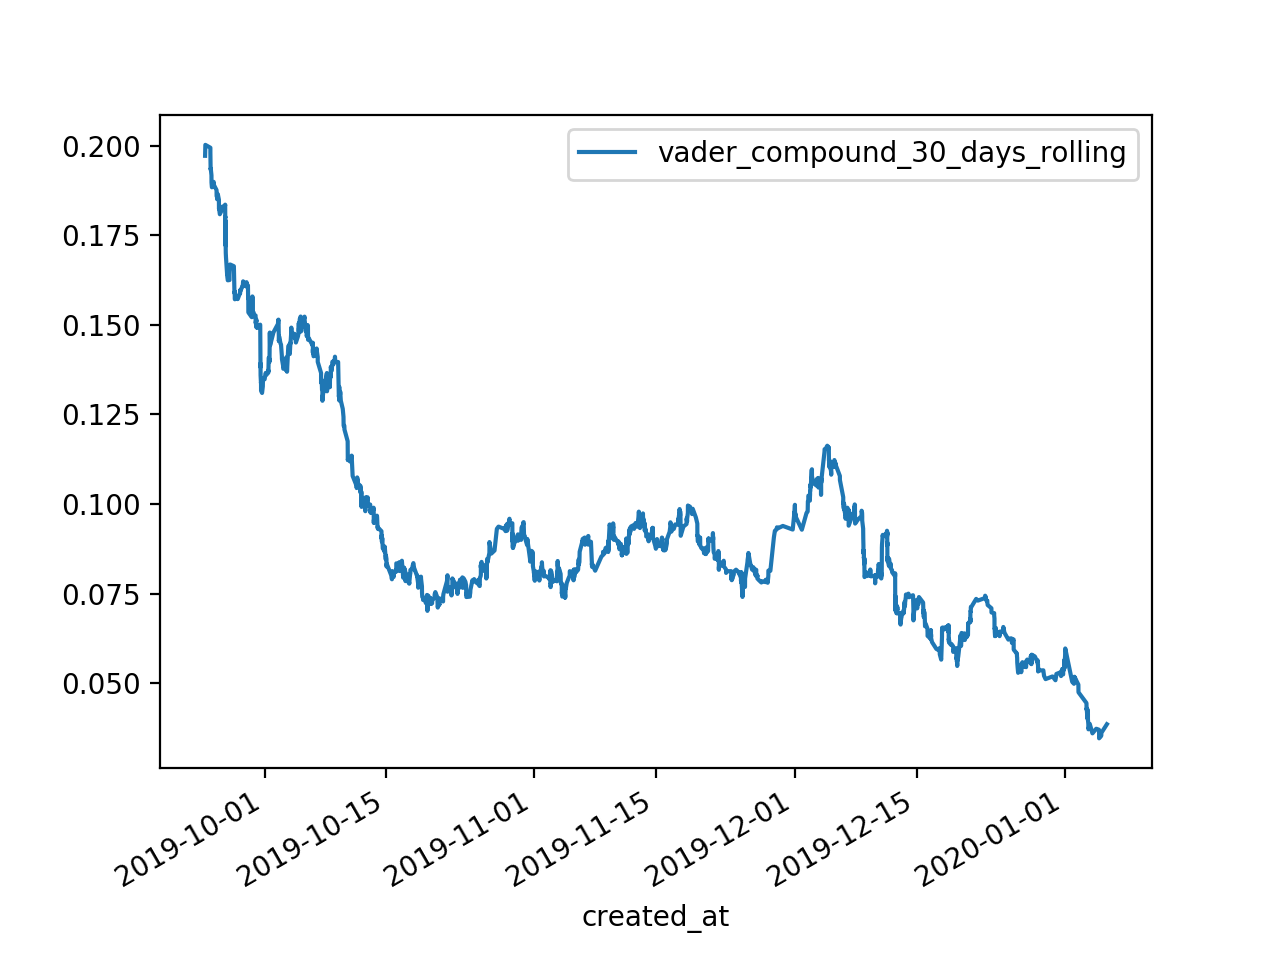

In [26]:
%matplotlib notebook
tweets[tweets['impeachment']].plot(x='created_at', y=['vader_compound_30_days_rolling'])

<IPython.core.display.Javascript object>


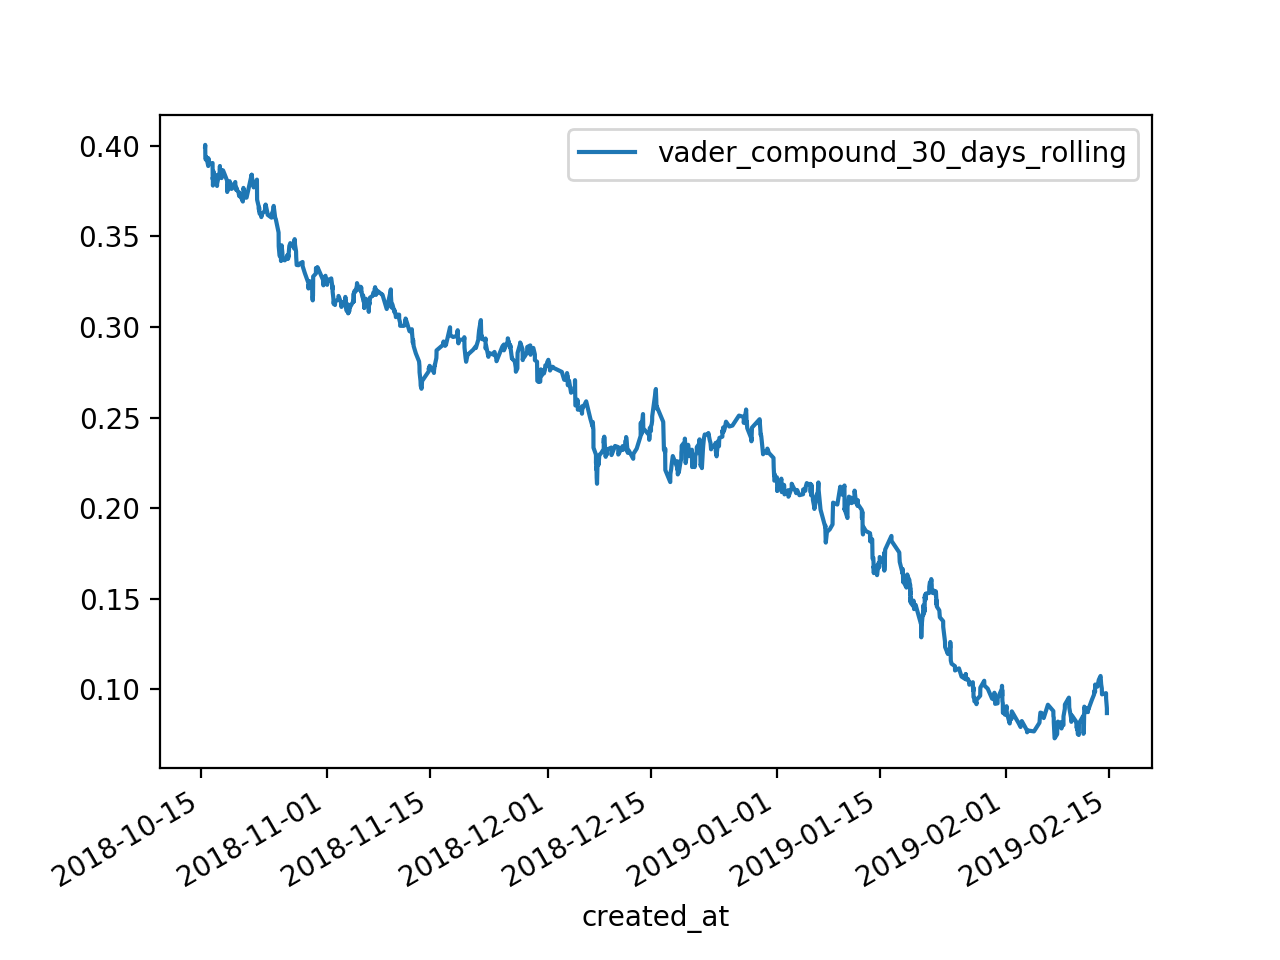

In [27]:
midterms = datetime.datetime(2018,10,15)
three_months_later = datetime.datetime(2019,2,15)

post_midterms = tweets[(tweets['created_at']>midterms) & (tweets['created_at']<three_months_later)]

post_midterms.plot(x='created_at', y=['vader_compound_30_days_rolling'])

<IPython.core.display.Javascript object>


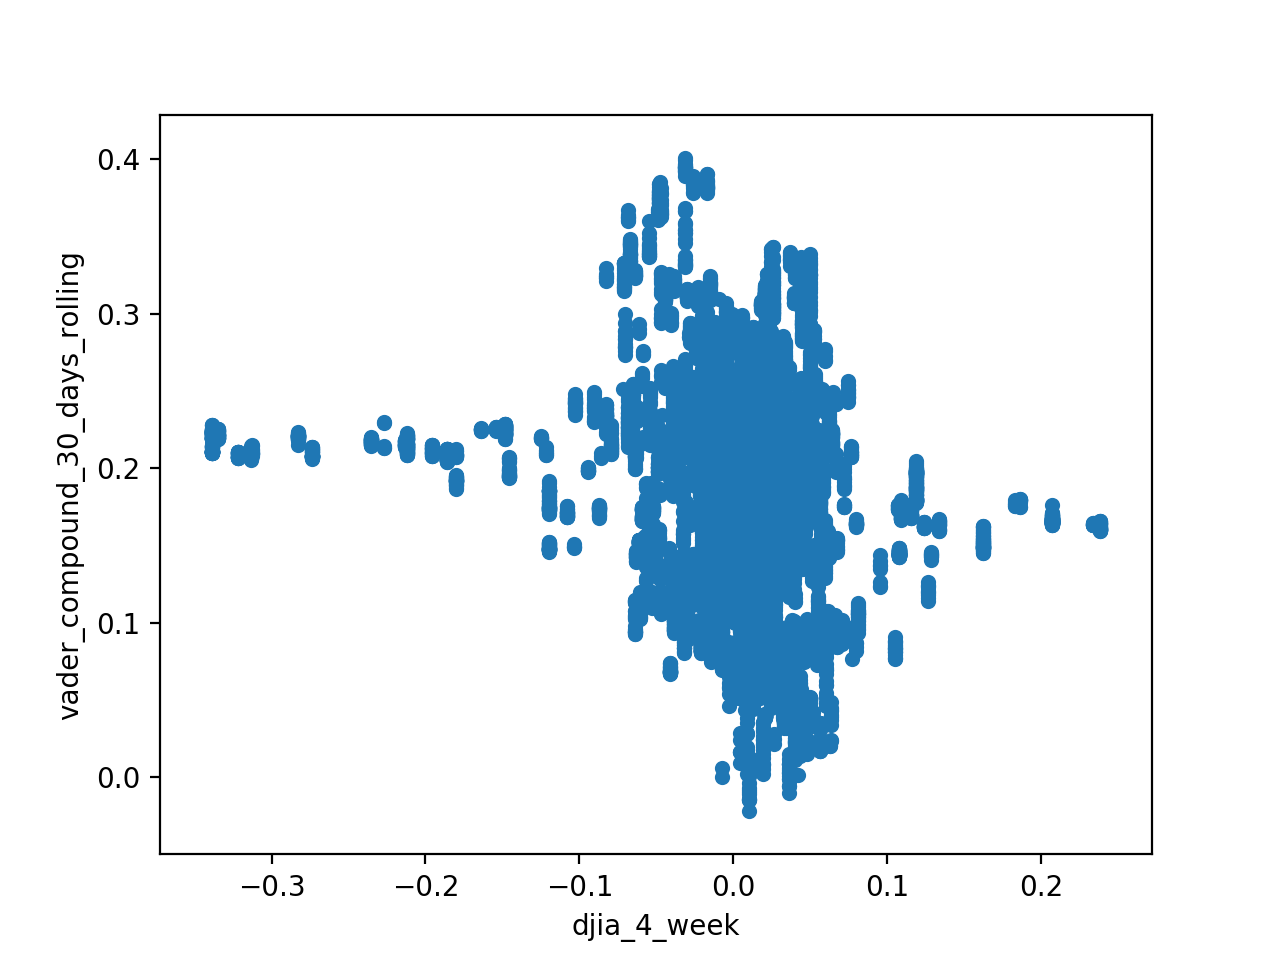

In [28]:
%matplotlib notebook

tweets.plot.scatter(x="djia_4_week", y="vader_compound_30_days_rolling")

<IPython.core.display.Javascript object>


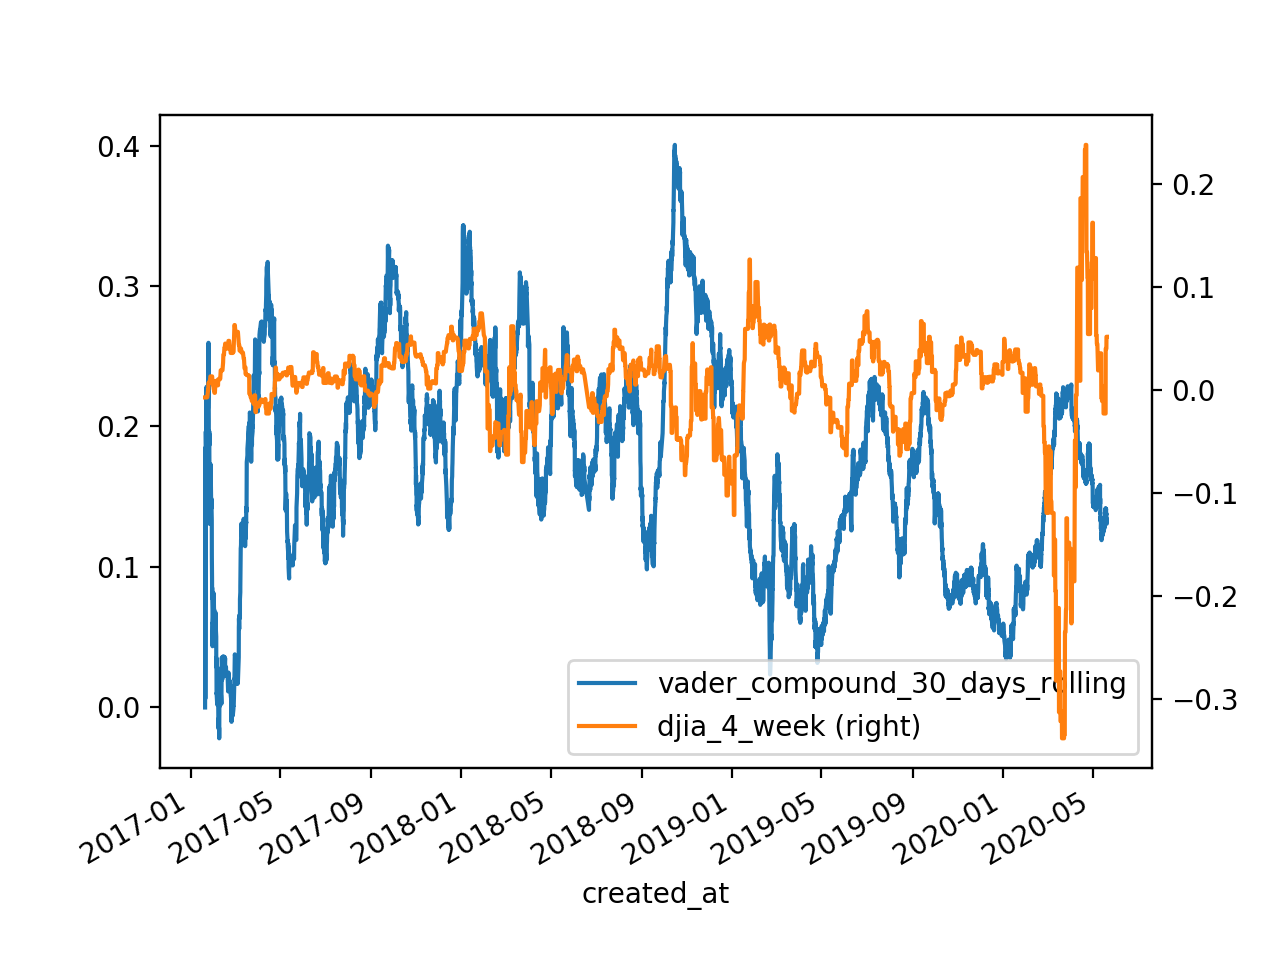

In [29]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1)
tweets.plot.line(x='created_at', y='vader_compound_30_days_rolling', ax=ax)
tweets.plot.line(x='created_at',y='djia_4_week', secondary_y=True, ax=ax)

<IPython.core.display.Javascript object>


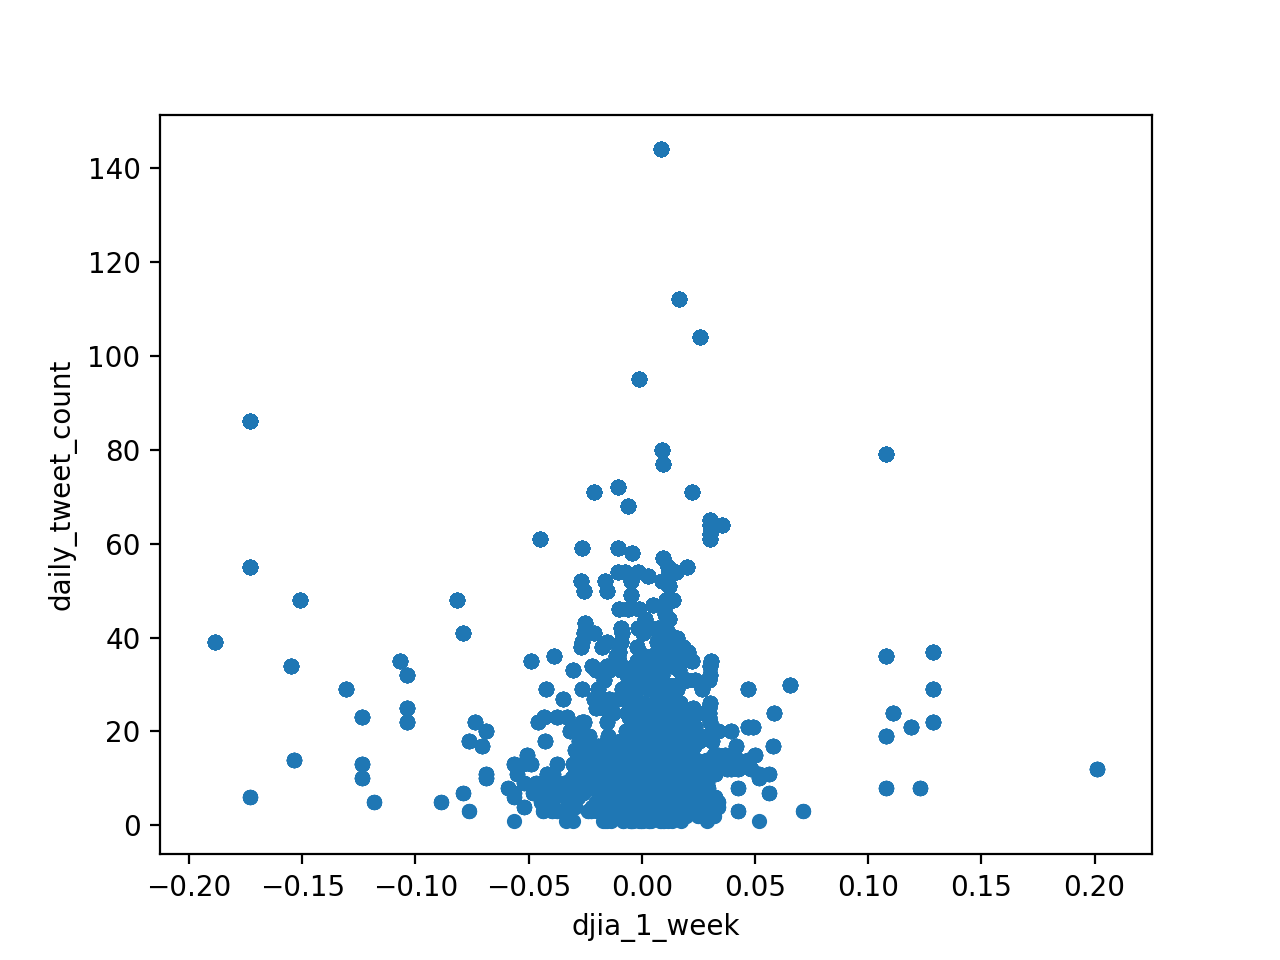

In [30]:
%matplotlib notebook

tweets.plot.scatter(x="djia_1_week", y='daily_tweet_count')

## Correlations

Correlations between relevant features are shown.

In [31]:
tweets[['vader_compound_7_days_rolling',
       'vader_compound_15_days_rolling',
       'vader_compound_30_days_rolling',
       'vader_compound_45_days_rolling',
       'vader_compound_60_days_rolling', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week', 'daily_tweet_count']].corr().loc[['vader_compound_7_days_rolling',
       'vader_compound_15_days_rolling',
       'vader_compound_30_days_rolling',
       'vader_compound_45_days_rolling',
       'vader_compound_60_days_rolling','daily_tweet_count']][['djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week']]

,djia_1_day,djia_1_week,djia_2_week,djia_3_week,djia_4_week
vader_compound_7_days_rolling,-0.058330,-0.087316,-0.110006,-0.133190,-0.154669
vader_compound_15_days_rolling,-0.055568,-0.120628,-0.154439,-0.173229,-0.190706
vader_compound_30_days_rolling,-0.041485,-0.071589,-0.133574,-0.171823,-0.195396
vader_compound_45_days_rolling,-0.034788,-0.013939,-0.056920,-0.090898,-0.127236
vader_compound_60_days_rolling,-0.023365,0.033502,0.001672,-0.023506,-0.046773
daily_tweet_count,-0.036961,-0.051183,-0.081824,-0.069560,-0.054704


## Statistical tests.

Statistical tests are run to see if there is a statistically significant difference between the sentiment in two different classes of tweets (e.g., during impeachment vs. not during impeachment).

In [32]:
from scipy import stats

down = tweets[tweets['djia_4_week']<-.025]
up = tweets[tweets['djia_4_week']>.025]

up_sent = up['vader_compound']
down_sent = down['vader_compound']

ttest,pval = stats.ttest_ind(up_sent, down_sent)
print(pval)

2.1229501284883814e-05


In [33]:
impeachment_sent = tweets[tweets['impeachment']]['vader_compound']
non_impeachment_sent = tweets[~tweets['impeachment']]['vader_compound']

ttest,pval = stats.ttest_ind(impeachment_sent, non_impeachment_sent)
print(pval)


4.76811303577635e-21


In [34]:
retweets_sent = retweets['vader_compound']
originals_sent = originals['vader_compound']

ttest,pval = stats.ttest_ind(retweets_sent, originals_sent)
print(pval)

2.8081715878562964e-20


In [35]:
positive = tweets[tweets['vader_compound']>0]
negative = tweets[tweets['vader_compound']<0]

positive_retweet = positive['retweet_count']
negative_retweet = negative['retweet_count']

ttest,pval = stats.ttest_ind(positive_retweet, negative_retweet)
print(pval)

5.2814391011481854e-24


In [36]:
positive_favorite = positive['favorite_count']
negative_favorite = negative['favorite_count']

ttest,pval = stats.ttest_ind(positive_favorite, negative_favorite)
print(pval)

0.7829890942766911


In [37]:
tweets_a_lot = tweets[tweets['daily_tweet_count']>=20]
tweets_little = tweets[tweets['daily_tweet_count']<20]

tweet_storm = tweets_a_lot['vader_compound']
non_storm = tweets_little['vader_compound']

ttest,pval = stats.ttest_ind(tweet_storm, non_storm)
print(pval)

2.034393753114304e-13


## When sentiment was tracking the market.

During the sumer of 2020, Trump's sentiment tracked the market very closely.

<IPython.core.display.Javascript object>


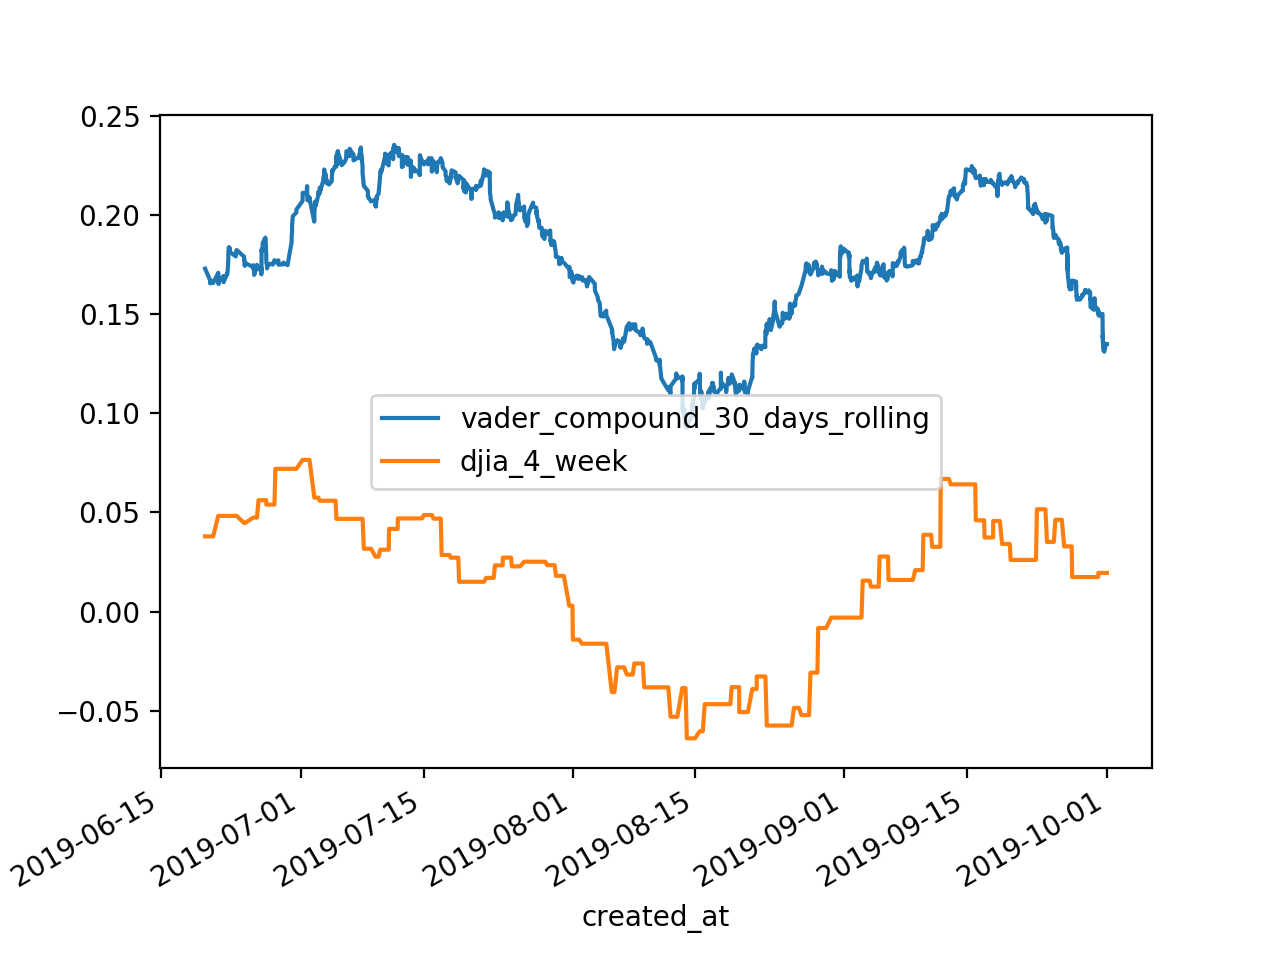

In [38]:
begin_v = datetime.datetime(2019,6,20)
end_v = datetime.datetime(2019,10,1)

v_tweets = tweets[(tweets['created_at']>begin_v) & (tweets['created_at']<end_v)]

v_tweets.plot(x='created_at', y=['vader_compound_30_days_rolling', 'djia_4_week'])

In [39]:
v_tweets[['vader_compound_7_days_rolling',
       'vader_compound_15_days_rolling',
       'vader_compound_30_days_rolling',
       'vader_compound_45_days_rolling',
       'vader_compound_60_days_rolling', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week', 'daily_tweet_count']].corr().loc[['vader_compound_7_days_rolling',
       'vader_compound_15_days_rolling',
       'vader_compound_30_days_rolling',
       'vader_compound_45_days_rolling',
       'vader_compound_60_days_rolling','daily_tweet_count']][['djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week']]

,djia_1_day,djia_1_week,djia_2_week,djia_3_week,djia_4_week
vader_compound_7_days_rolling,-0.024399,0.367769,0.415161,0.341243,0.271696
vader_compound_15_days_rolling,0.119926,0.516247,0.602459,0.556879,0.538146
vader_compound_30_days_rolling,0.167769,0.372819,0.677428,0.776525,0.817474
vader_compound_45_days_rolling,0.206908,0.011399,0.237325,0.433553,0.648463
vader_compound_60_days_rolling,0.085686,-0.130245,0.006160,-0.031598,0.107520
daily_tweet_count,-0.081988,0.145033,0.032443,-0.070953,-0.043576


## Playing with KMeans.
I spent a little time exploring the data with KMeans, but didnt' spend enough time to find any interesting patterns.

<IPython.core.display.Javascript object>


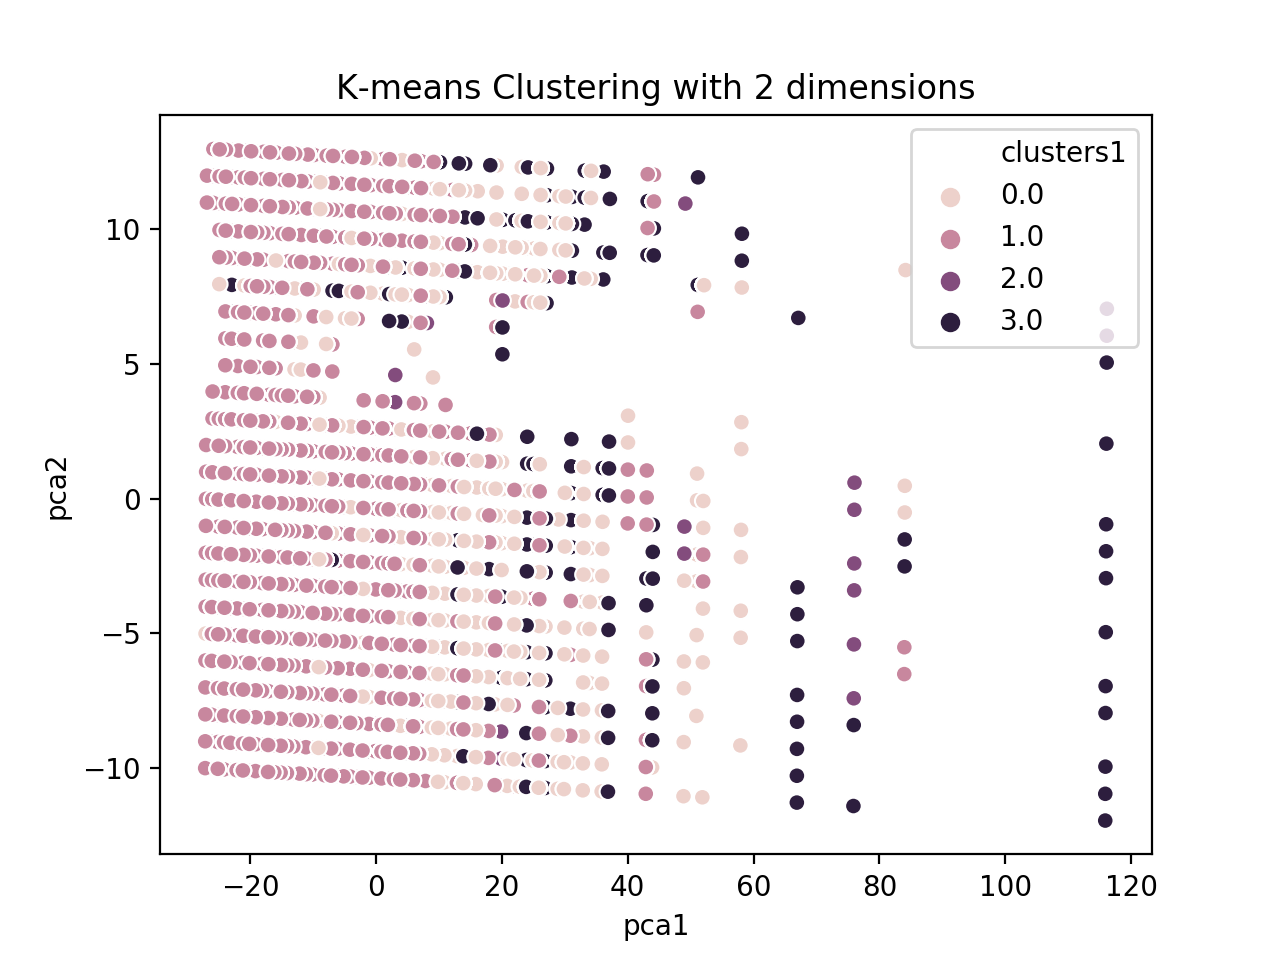

In [56]:
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=4)
tweets['clusters1'] = kmeans.fit_predict(tweets[['hour', 'vader_compound', 'daily_tweet_count']])

%matplotlib notebook

reduced_data = PCA(n_components=2).fit_transform(tweets[['hour', 'vader_compound', 'contains_RT', 'daily_tweet_count']])
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=tweets['clusters1'], data=results, legend='full')
plt.title('K-means Clustering with 2 dimensions')
plt.show()



<IPython.core.display.Javascript object>


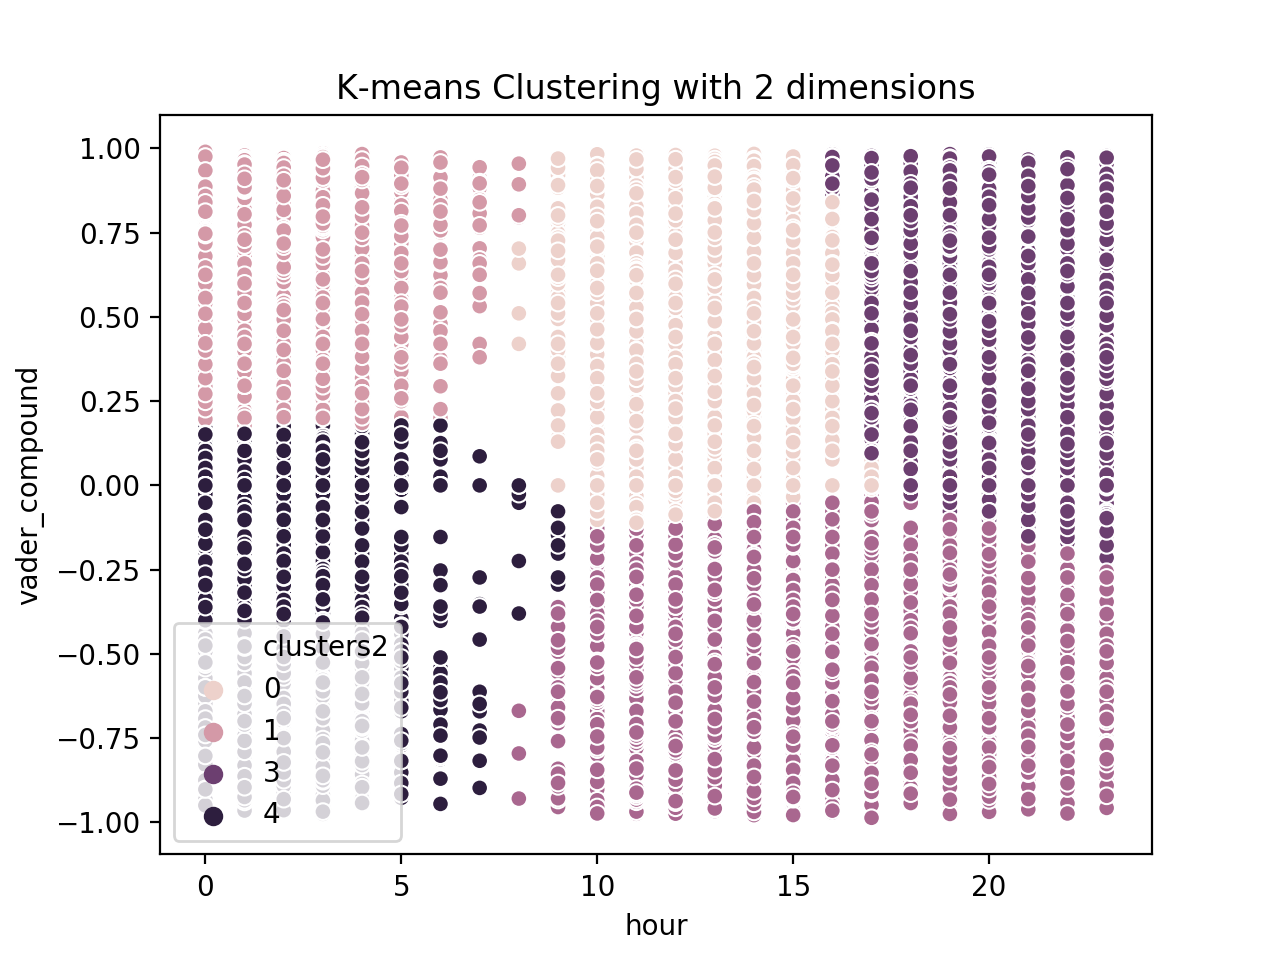

In [57]:
%matplotlib notebook

kmeans = KMeans(n_clusters=5)

tweets['hour_norm'] = (tweets['hour']-tweets['hour'].mean())/tweets['hour'].std()
tweets['vader_compound_norm'] = (tweets['vader_compound']-tweets['vader_compound'].mean())/tweets['vader_compound'].std()

tweets['clusters2'] = kmeans.fit_predict(tweets[['hour_norm', 'vader_compound_norm']])

%matplotlib notebook
sns.scatterplot(x=tweets["hour"], y=tweets["vader_compound"], hue=tweets['clusters2'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

## To Dos

* compare to Obama
* redo all graphs with original tweets only
* examples of pos/neg tweets
* dictionary of words and hashtags